In [2]:
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Activation, BatchNormalization
from keras import optimizers
from keras import metrics
from keras import models
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow
import functools
from sklearn.utils import class_weight, shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import numpy as np
import common

print(tensorflow.config.list_physical_devices('GPU'))
print(tensorflow.test.is_built_with_cuda())

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
True


In [3]:
train = common.load_train_dataset('dataset_mini/train.csv')

train = train[~train["attribute_ids"].isin(["51", "13"])]

print('Number of train samples: ', train.shape[0])
display(train.head())


test = common.load_train_dataset('dataset_mini/test.csv')

test = test[~test["attribute_ids"].isin(["51", "13"])]

print('Number of test samples: ', test.shape[0])
display(test.head())

labels = np.unique(train["attribute_ids"])

Number of train samples:  4991


,id,attribute_ids
13894,a744b3b73ec2739c.png,40
18607,db6c8743313fc13c.png,29
16343,c1a0f30ecbdccb89.png,25
7143,5e7ce0188ee4c82f.png,18
19237,e209672477d16f09.png,65


Number of test samples:  491


,id,attribute_ids
262,ecfec61a60283252.png,35
642,f0cf510978b40efb.png,67
54,eac1f1609122a473.png,67
1680,fbbd44f2af562108.png,70
1200,f6cc6ea8ff775fa7.png,54


In [4]:
# Model parameters
BATCH_SIZE = 128
EPOCHS = 30
LEARNING_RATE = 0.0001
HEIGHT = 224
WIDTH = 224
CANAL = 3
N_CLASSES = len(labels)

In [5]:
train_generator, valid_generator, test_generator = common.create_image_generators("dataset_mini/data", "dataset_mini/data", train, test, BATCH_SIZE, (HEIGHT, WIDTH), data_augmentation=True)

Found 3988 validated image filenames belonging to 48 classes.
Found 996 validated image filenames belonging to 48 classes.
Found 491 validated image filenames belonging to 48 classes.
C:\Users\henri\AppData\Local\Programs\Python\Python39\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 7 invalid image filename(s) in x_col="id". These filename(s) will be ignored.
  warnings.warn(
C:\Users\henri\AppData\Local\Programs\Python\Python39\lib\site-packages\keras_preprocessing\image\dataframe_iterator.py:279: UserWarning: Found 7 invalid image filename(s) in x_col="id". These filename(s) will be ignored.
  warnings.warn(


In [7]:
model = models.Sequential()

model.add(Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), padding='Same', input_shape=(HEIGHT, WIDTH, CANAL)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=256, kernel_size=(5,5), padding='Same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=384, kernel_size=(3,3), padding='Same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(filters=384, kernel_size=(3,3), padding='Same'))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(Conv2D(filters=256, kernel_size=(3,3), padding='Same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(4096))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(4096))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(N_CLASSES, activation="softmax"))
model.summary()

top3_acc = functools.partial(metrics.top_k_categorical_accuracy, k=3)
top3_acc.__name__ = 'top3_acc'

top5_acc = functools.partial(metrics.top_k_categorical_accuracy, k=5)
top5_acc.__name__ = 'top5_acc'

optimizer = optimizers.Adam(learning_rate=LEARNING_RATE)
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy", top3_acc, top5_acc])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 56, 56, 96)        34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 56, 56, 96)        384       
_________________________________________________________________
activation (Activation)      (None, 56, 56, 96)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 28, 28, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 256)       1024      
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 256)       0

In [6]:
STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size

history = model.fit(train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=EPOCHS,
                    verbose=1)

model.save('task1_cnn_48')

Epoch 1/30
34/34 [==============================] - 82s 2s/step - loss: 3.3847 - accuracy: 0.2376 - top3_acc: 0.3884 - top5_acc: 0.4608 - val_loss: 3.5172 - val_accuracy: 0.1436 - val_top3_acc: 0.2578 - val_top5_acc: 0.3838
Epoch 2/30
34/34 [==============================] - 57s 2s/step - loss: 2.3846 - accuracy: 0.3936 - top3_acc: 0.6056 - top5_acc: 0.6985 - val_loss: 3.6279 - val_accuracy: 0.1523 - val_top3_acc: 0.2656 - val_top5_acc: 0.3154
Epoch 3/30
34/34 [==============================] - 57s 2s/step - loss: 2.0572 - accuracy: 0.4566 - top3_acc: 0.6672 - top5_acc: 0.7484 - val_loss: 3.8905 - val_accuracy: 0.0752 - val_top3_acc: 0.2549 - val_top5_acc: 0.3213
Epoch 4/30
34/34 [==============================] - 57s 2s/step - loss: 1.9742 - accuracy: 0.4720 - top3_acc: 0.6826 - top5_acc: 0.7641 - val_loss: 4.4106 - val_accuracy: 0.0801 - val_top3_acc: 0.1250 - val_top5_acc: 0.2188
Epoch 5/30
34/34 [==============================] - 58s 2s/step - loss: 1.9184 - accuracy: 0.4893 - top3

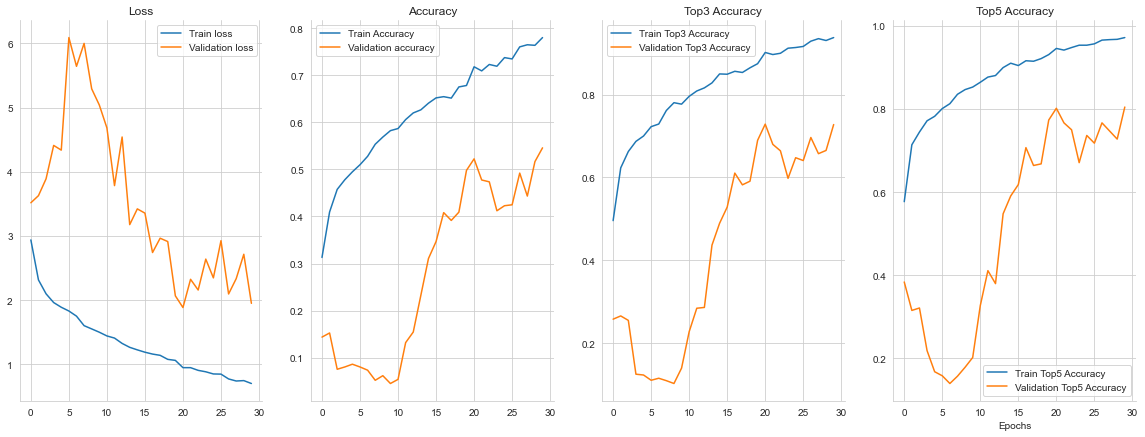

In [9]:
common.plot_history(history, ["loss", "accuracy", "top3_acc", "top5_acc"])

In [8]:
model = models.load_model('task1_cnn_48', custom_objects={'top3_acc': top3_acc, 'top5_acc': top5_acc})
model.evaluate(test_generator, verbose=1)

491/491 [==============================] - 16s 7ms/step - loss: 1.0503 - accuracy: 0.6782 - top3_acc: 0.8961 - top5_acc: 0.9369


[1.0503329038619995,
 0.6782077550888062,
 0.8961303234100342,
 0.9368635416030884]

In [19]:
preds = model.predict(test_generator)

matrix = confusion_matrix(test_generator.classes, np.argmax(preds, axis=1))
print(matrix)
class_labels = list(test_generator.class_indices.keys())
report = classification_report(test_generator.classes, np.argmax(preds, axis=1), labels=np.unique(train["attribute_ids"]).astype(int), zero_division=0)
print(report)


[[ 1  0  0 ...  0  0  0]
 [ 0  4  0 ...  0  1  0]
 [ 0  0  2 ...  0  0  0]
 ...
 [ 0  0  0 ...  0  2  0]
 [ 0  0  0 ...  0 69  0]
 [ 0  0  0 ...  0  0  0]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         1
           1       1.00      0.36      0.53        11
          10       0.00      0.00      0.00         4
          12       1.00      0.80      0.89         5
          14       0.47      0.47      0.47        19
          15       1.00      1.00      1.00         1
          16       0.33      1.00      0.50         1
          17       0.47      0.73      0.57        49
          18       0.00      0.00      0.00         4
           2       1.00      1.00      1.00         2
          22       0.00      0.00      0.00         3
          23       0.88      0.44      0.58        16
          24       0.00      0.00      0.00         3
          25       1.00      0.40      0.57        10
          26       0.00      0.00